In [2]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
#import nimfa

In [3]:
def FA_L1(X, num_factors, sparsity_scale=0.03, sparse=False):
    
    num_samples, num_features = X.shape

    # # Priors for the factor loadings with L1 regularization (Laplace prior)
    # with numpyro.plate('Features', num_factors):
    #     if sparse:
    #         f = numpyro.sample('features', dist.Laplace(0, sparsity_scale).expand([num_features]).to_event(1))
    #     else:
    #         f = numpyro.sample('features', dist.Normal(0, 1).expand([num_features]).to_event(1))

    f = numpyro.sample('features', dist.Laplace(jnp.zeros((num_factors, num_features)), sparsity_scale))
    # print(f.shape)

    # # Priors for the latent factors
    # with numpyro.plate('Samples', num_factors):
    #     if sparse:
    #         s = numpyro.sample('samples', dist.Laplace(0, sparsity_scale).expand([num_samples]).to_event(1))
    #     else:
    #         s = numpyro.sample('samples', dist.Normal(0, 1).expand([num_samples]).to_event(1))

    # print(s.shape)
    s = numpyro.sample('samples', dist.Laplace(jnp.zeros((num_factors, num_samples)), sparsity_scale))

    
    # Likelihood
    numpyro.sample('obs', dist.Normal(jnp.matmul(s.T, f), 1), obs=X)

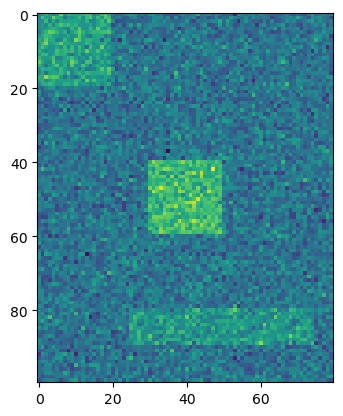

In [4]:
# Example usage
X = np.random.randn(100, 80)  # Replace with your data
# add a rank-1 submatries with a sparse factorization
X[:20, :20] += 2.0
X[40:60, 30:50] += 3.0
X[80:90, 25:75] += 1.5

plt.imshow(X)
num_factors = 5 # Number of latent factors

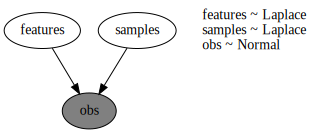

sample: 100%|██████████| 1500/1500 [00:08<00:00, 179.71it/s, 31 steps of size 1.01e-01. acc. prob=0.83]


(5, 80)
(5, 100)


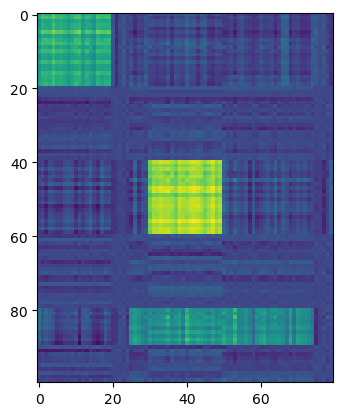

In [6]:
# render the model
#numpyro.render_model(FA_L1, model_args=(X,num_factors), render_distributions=True)

# Running MCMC
kernel = NUTS(FA_L1)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), X, num_factors, sparsity_scale=1.0)

# Getting the posterior samples
posterior_samples = mcmc.get_samples()

# plot the reconstructed X matrix
f=posterior_samples['features'].mean(axis=0)
s=posterior_samples['samples'].mean(axis=0)
print(f.shape)
print(s.shape)
plt.imshow(np.matmul(s.T, f))
plt.show()

(5, 80)
(5, 100)


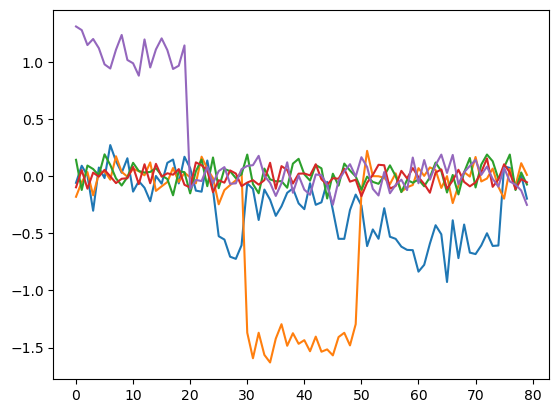

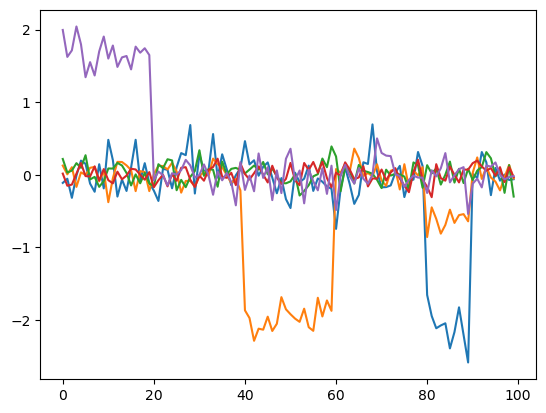

In [37]:
print(f.shape)
print(s.shape)
plt.plot(f.T)
plt.show()
plt.plot(s.T)
plt.show()

In [57]:

#nsnmf = nimfa.Lsnmf(X - X.min(), seed='random_vcol', rank=5, max_iter=100)
snmf = nimfa.Snmf(X - X.min(), seed="random_vcol", rank=5, max_iter=100, version='l', eta=1., beta=1e-4, i_conv=10, w_min_change=0)
snmf_fit = snmf()

print('Rss: %5.4f' % snmf_fit.fit.rss())
print('Evar: %5.4f' % snmf_fit.fit.evar())
print('K-L divergence: %5.4f' % snmf_fit.distance(metric='kl'))
print('Sparseness, W: %5.4f, H: %5.4f' % snmf_fit.fit.sparseness())

Rss: 6805.9386
Evar: 0.9553
K-L divergence: 883.0994
Sparseness, W: 0.2008, H: 0.1767


In [58]:
print(snmf.H.shape)
print(snmf.W.shape)

(5, 80)
(100, 5)


In [64]:
snmf.estimate_rank(rank_range=[2, 3, 4, 5, 6, 7, 8, 9, 10])

{2: {'rank': 2,
  'sparseness': (0.17043941536090185, 0.07848730521137197),
  'rss': 8510.694492726849,
  'evar': 0.9441434351921689,
  'residuals': matrix([[ 1.4421407 ,  0.01104148,  0.67613772, ..., -0.55646051,
           -0.44693541, -0.29093459],
          [ 1.82262368,  0.74926043,  0.01472083, ..., -1.13690764,
            0.53495123, -2.15279652],
          [-1.22694358,  0.60831575,  0.7285955 , ..., -0.17456592,
           -1.00068711, -0.60416795],
          ...,
          [ 0.21102411, -0.05821544, -0.42750618, ...,  1.0899458 ,
            0.72996926,  0.74072234],
          [-2.31392978,  0.68805953, -0.82503655, ...,  1.21468275,
            1.09353549, -0.89038637],
          [ 1.66999275, -0.56140513, -0.65329407, ...,  1.15667583,
            0.69402676,  1.22934227]]),
  'connectivity': matrix([[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
     

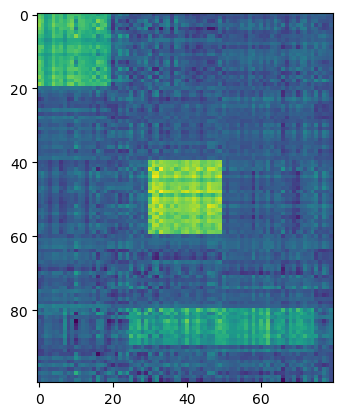

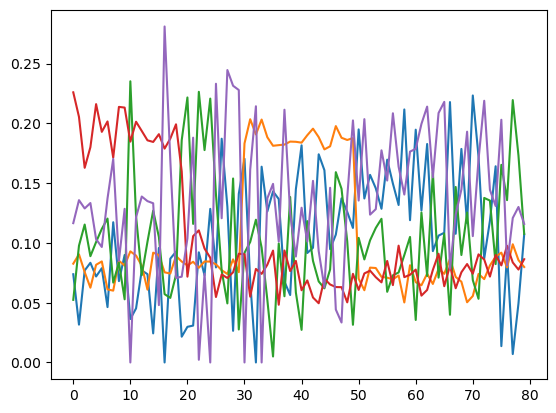

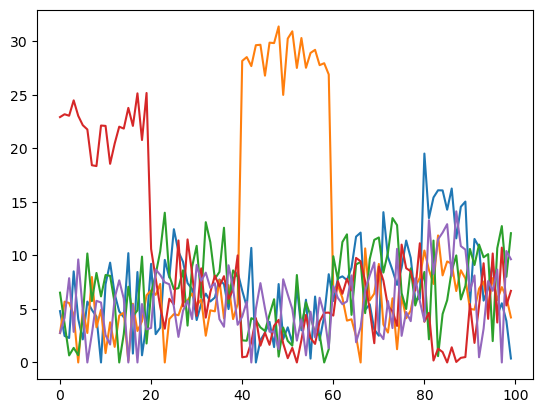

In [61]:
plt.imshow(snmf.fitted())
plt.show()

plt.plot(snmf.H.T)
plt.show()
plt.plot(snmf.W)
plt.show()